In [86]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230320',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

query = '''
select user_id,
        toDate(time) as date,
        country,
        city,
        os
from {db}.feed_actions 
where date = '2023-03-24' or date = '2023-03-23'
'''

df = ph.read_clickhouse(query, connection=connection)


In [87]:
# Перевод даты в более удобный формат
df['date'] = df.date.dt.day

Проверим, есть ли влияние os на спад активности пользователей

In [88]:
df.groupby(['date','os']).agg({'user_id': 'nunique'})

user_id
date os              
23   Android    11173
     iOS         5959
24   Android     9235
     iOS         4838

Видно, что количество уникальных пользователей упало в обоих системах, значит, проблема не в этом 
Проверим активных пользователей по странам

<AxesSubplot:xlabel='country', ylabel='user_id'>

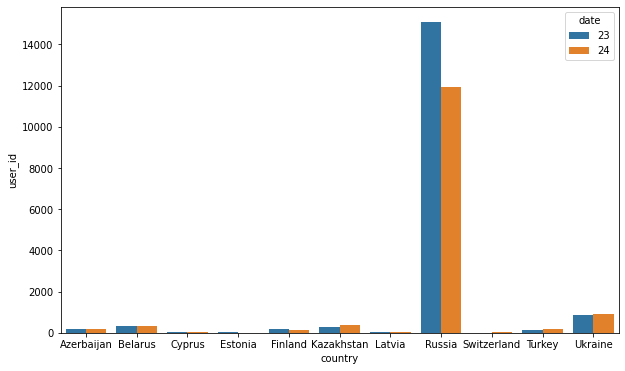

In [89]:
# Посчет количества активных пользователей в каждой стране
df_by_country = df.groupby(['date','country'], as_index=False).agg({'user_id': 'nunique'})

# Визуализируем полученные данные для наглядности
plt.figure(figsize=(10, 6))
sns.barplot(data=df_by_country, x="country", y="user_id", hue="date")

Видно, что активных пользователей стало меньше именно в России, посмотрим чуть подробнее


In [90]:
# Посчет активных пользователей в каждом городе
df_by_city = df.query('country == "Russia"')\
                .pivot_table(index='city', 
                             columns='date', 
                             values='user_id',
                             aggfunc='nunique',
                            fill_value = 0)\
                .reset_index()
#Посчет разницы между активными пользователями 23 и 24 марта 
df_by_city['diff'] = df_by_city[23] - df_by_city[24]

#Сортировка по величине различий
df_by_city.sort_values('diff', ascending=False)

date,city,23,24,diff
841,Moscow,2319,0,2319
1152,Saint Petersburg,764,0,764
957,Novosibirsk,213,0,213
1603,Yekaterinburg,210,0,210
253,Chelyabinsk,195,155,40
...,...,...,...,...
1545,Volgograd,129,147,-18
1159,Samara,160,181,-21
1448,Ulyanovsk,77,102,-25
247,Cheboksary,49,75,-26


Из датафрейма видно, что 24 марта пользователи из Москвы, Санкт-Петербурга, Новосибирска и Екатеринбурга не смогли зайти в наше приложение